In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Convolutional Layers 

In [11]:
conv1 = nn.Conv2d(1, 6, 3, 1) # ----> 6 filters --> pooling --> Conv2 : th output channel will be 6
"""
In the layer, we did not add padding, coz in MNIST data, all information on center, so no plm if we loss the border of image
"""
# the 6 for input channel com from Conv1, 16 filter (optional)
conv2 = nn.Conv2d(6, 16, 3, 1)

# First Batch of data

In [12]:
# get first batch of data
for i, (X_train, y_train) in enumerate(train_data):
    break

In [13]:
X_train.shape

torch.Size([1, 28, 28])

In [14]:
x = X_train.view(1, 1, 28, 28) # change it to 4D

In [15]:
x = F.relu(conv1(x))

In [16]:
x.shape

# the output will be
# [ Number of sample,
#   Number of channel(NO.Filter that applied),
#   the output size (will be different coz we loss some data)]


torch.Size([1, 6, 26, 26])

In [17]:
# Add pooling layer
x = F.max_pool2d(x, 2, 2)

In [18]:
x.shape

# the output will be
# [ Number of sample,
#   Number of channel(NO.Filter that applied),
#   the output size (will be different coz we apply Max_Pooling with 2*2, that mean cut the size ti half)]


torch.Size([1, 6, 13, 13])

In [19]:
x = F.relu(conv2(x))

In [20]:
x.shape

torch.Size([1, 16, 11, 11])

In [21]:
x = F.max_pool2d(x, 2, 2)

In [22]:
x.shape

torch.Size([1, 16, 5, 5])

In [23]:
# Flatten the data: To fit it into our model, should be flatten
x.view(-1, 16 * 5 * 5).shape

torch.Size([1, 400])

# Create / Build oue MODEL with CNN layer

In [24]:
class ConvNetwork(nn.Module):
    
    def __init__(self, in_sz = 5*5*16, out_sz=10, layers=[120, 84]):
        super().__init__()
        
        # CNN layers 
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2= nn.Conv2d(6, 16, 3, 1) # the output will be [1, 16, 5, 5]  --> should reshape it before fit it into full connecting layers 
        
        
        
        # Full connect Linear Layers 
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])    
        self.fc3 = nn.Linear(layers[1], out_sz) 
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 5 * 5) # Should be flatten to fit it to full connection layer 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X)) 
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [25]:
torch.manual_seed(42)
model = ConvNetwork()
model

ConvNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [25]:
 print('Total Parameters = ', 54 +6 +864 +16 + 48000 +120 +10080 +84 +840 +10 )

Total Parameters =  60074


# Set the Loss Function and the Optimizer

In [26]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
import time
start = time.time()

# TRAINING ----
epochs = 5

# TRACKERS ----
train_losses = []  
test_losses = []  
train_correct = [] 
test_correct = []

# START FOR LOOP EPOCHS
for i in range(epochs):
    trn_correct = 0
    tst_correct = 0

    # TRAIN 
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # No need to Flatten it 
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if b % 600 == 0:
            accuracy = (trn_correct.item() * 100) / (100 * b)
            print(f"Epoch: {i}  batch: {b}  loss: {loss.item()}  accuracy: {accuracy}")


    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_correct.item())

    
    
    # TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1
            y_val = model(X_test) 
            
            predicted = torch.max(y_val.data, 1)[1] 
            tst_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)  
    test_losses.append(loss.detach().numpy()) 
    test_correct.append(tst_correct.item())



# Display the Duration. Time that takes to train the model
total_time = time.time() - start  
print(f"Duration: {total_time/60} mins")

Epoch: 0  batch: 600  loss: 0.04255055636167526  accuracy: 7.848333333333334
Epoch: 0  batch: 1200  loss: 0.07605954259634018  accuracy: 8.5825
Epoch: 0  batch: 1800  loss: 0.363738477230072  accuracy: 8.866111111111111
Epoch: 0  batch: 2400  loss: 0.026480620726943016  accuracy: 9.047916666666667
Epoch: 0  batch: 3000  loss: 0.00858532078564167  accuracy: 9.164
Epoch: 0  batch: 3600  loss: 0.0012412868672981858  accuracy: 9.248055555555556
Epoch: 0  batch: 4200  loss: 0.5668128728866577  accuracy: 9.314761904761905
Epoch: 0  batch: 4800  loss: 0.031286485493183136  accuracy: 9.359791666666666
Epoch: 0  batch: 5400  loss: 0.014834213070571423  accuracy: 9.401851851851852
Epoch: 0  batch: 6000  loss: 0.041800253093242645  accuracy: 9.433166666666667
Epoch: 1  batch: 600  loss: 0.02671869657933712  accuracy: 9.78
Epoch: 1  batch: 1200  loss: 0.033834896981716156  accuracy: 9.785833333333333
Epoch: 1  batch: 1800  loss: 0.0015030563808977604  accuracy: 9.786111111111111
Epoch: 1  batch: 2

In [27]:
# Plot the Losses for Train and Test
plt.plot(train_losses, label="Training losses")
plt.plot(test_losses, label="Test losses")
plt.legend()

NameError: name 'train_losses' is not defined

In [ ]:
#  Plot the Accuracy for Train and Test
plt.plot([t/600 for t in train_correct], label='Training accuracy')
plt.plot([t/100 for t in test_correct], label='Test accuracy')
plt.legend()

# New Unseen Data

In [34]:
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False) 

In [37]:
 with torch.no_grad():
        correct =0 
        
        for (X_test, y_test) in test_loader_all:
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]

            correct += (predicted == y_test).sum()

# Create a new Prediction  

In [86]:
test_data[2000][0].view(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922,
         0.6235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.4863, 0.4431,
         0.3020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [87]:
test_data[2000]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1922, 0.6235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471,
           0.4863, 0.4431, 0.3020, 0.0000, 

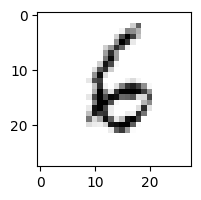

In [88]:
plt.figure(figsize=(2, 2))
test_data_view = test_data[2000][0].view(28, 28)
plt.imshow(test_data_view, cmap="gist_yarg")

In [89]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[2000][0].view(1, 1, 28, 28))
    predicted = torch.max(new_pred.data, 1)[1]
    print(predicted)
    

tensor([6])


In [90]:
new_pred.shape

torch.Size([1, 10])

In [91]:
predicted = torch.max(new_pred.data, 1)[1]

In [92]:
predicted

tensor([6])

In [95]:
torch.cuda.is_available()

False

In [96]:
torch.cuda.is_available()

False